# Workshop in Probability and Statistics

In [1]:
from IPython.display import display, HTML
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

%matplotlib inline

## 1. Banjir Jakarta

Menurut [berita](https://www.beritasatu.com/megapolitan/250044/jakarta-urban-coalition-banjir-februari-2015-paling-parah), banjir Jakarta di bulan Februari 2015 adalah salah satu yang terparah sejak 2007. Dalam kasus di bawah ini, data yang digunakan didapatkan dari tingkat kelurahan. Data diperoleh dari data.go.id.

In [101]:
url_banjir_2015 = 'http://data.jakarta.go.id/dataset/df0b85a1-b9df-4aee-ad83-cb220ed84993/resource/d4ff93bd-bf81-4d6b-a26a-061775bc0364/download/Data-Kejadian-Banjir-Bulan-Februari-Tahun-2015.csv'

urls = [
    'http://data.jakarta.go.id/dataset/d8272c29-e0a4-4cca-bc30-db9e48ed02a5/resource/863b8e52-4369-452a-9d71-15545074717c/download/Data-Curah-Hujan-Dan-Hari-Hujan-Di-DKI-Jakarta-Menurut-Bulan-Tahun-2011.csv',
    'http://data.jakarta.go.id/dataset/d8272c29-e0a4-4cca-bc30-db9e48ed02a5/resource/a392be77-d821-4b32-b673-c9d53bcaeff3/download/Data-Curah-Hujan-Dan-Hari-Hujan-Di-DKI-Jakarta-Menurut-Bulan-Tahun-2012.csv',
    'http://data.jakarta.go.id/dataset/d8272c29-e0a4-4cca-bc30-db9e48ed02a5/resource/2760d910-9e32-4ba1-8e0e-5076933faadd/download/Data-Curah-Hujan-Dan-Hari-Hujan-Di-DKI-Jakarta-Menurut-Bulan-Tahun-2013.csv',
    'http://data.jakarta.go.id/dataset/d8272c29-e0a4-4cca-bc30-db9e48ed02a5/resource/2b7645c9-6542-40e2-9b2c-4efc85f5c6a8/download/Data-Curah-Hujan-Dan-Hari-Hujan-Di-DKI-Jakarta-Menurut-Bulan-Tahun-2014.csv'
]

rt_rw_url = 'http://data.jakarta.go.id/dataset/3e2302de-3f82-43bc-ab33-78e7ae9732aa/resource/aafc5c0e-874b-4404-a1f0-2aace03c794e/download/RT-RW-LMK-2016EDITED.xls'

### Soal 1.1

Muat dan bersihkan data dari URL di atas

In [59]:
banjir_feb = pd.read_csv(url_banjir_2015)

curah = pd.DataFrame(columns=['tahun','bulan','curah_hujan','banyak_hari_hujan'])
for url in urls:
    curah = pd.concat([
        curah,
        pd.read_csv(url).dropna()
    ])
curah['index'] = pd.date_range('2011-01-01', '2014-12-31', freq='1M')
curah = curah.set_index('index')

In [102]:
rt_rw = pd.read_excel(rt_rw_url)

In [60]:
curah = curah.astype({
    'tahun': 'int',
    'bulan': 'int'
})
curah['curah_hujan'] = curah['curah_hujan'].apply(lambda x: str(x).replace(',','.')).astype('float')
curah['banyak_hari_hujan'] = curah['banyak_hari_hujan'].apply(lambda x: str(x).replace(',','.')).astype('float')

### Soal 1.2.a

Jika dilihat dari data seluruh kota administrasi di Jakarta, sekitar 18% RW per kelurahan akan terkena banjir. Jika jumlah RW di kelurahan Pulo Gebang adalah 16, berapa peluangnya RW yang terkena banjir kurang dari 5?

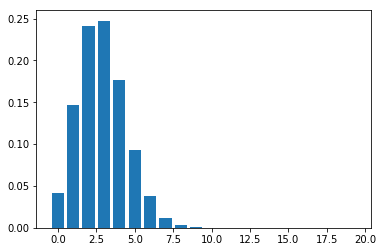

In [237]:
from scipy.stats import binom

k = np.arange(20)
plt.bar(k, binom.pmf(k, n=16, p=.18));
display(HTML('$P(X\leq4)={:.2f}$'.format(
    binom.cdf(5, n=16, p=.18)
)))

### Soal 1.2.b

Bandingkan dengan data sebenarnya, apakah prediksi Anda tepat?

In [78]:
banjir_feb.query('kelurahan == "Pulo Gebang"').jumlah_rw

89    3
Name: jumlah_rw, dtype: int64

### Soal 1.2.c

Apakah model ini sudah cukup untuk digeneralisasi? Apa masalahnya? Apa yang dapat diusulkan untuk memperbaiki model ini?

*Jawaban Anda di sini*

### Soal 1.3.a

Berdasarkan data, diketahui bahwa rata-rata jumlah RW per kelurahan yang terkena dampak banjir adalah 4.62. Jika kita mengasumsikan bahwa kelurahan yang masih dianggap aman adalah kelurahan dengan jumlah RW yang terkena dampak banjir tidak lebih dari 2, berapa peluangnya kita menemukan kelurahan yang tergolong aman?

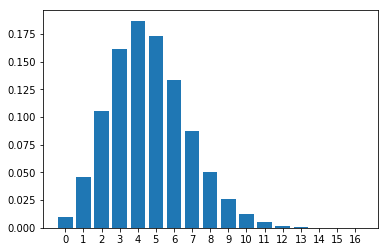

In [240]:
from scipy.stats import poisson

k = np.arange(17)
plt.bar(k, poisson.pmf(k, 4.62))
plt.xticks(k);
display(HTML('$P(X \leq 2)={:.2f}$'.format(
    poisson.cdf(2, 4.62)
)))

### Soal 1.3.b

Bandingkan dengan datanya, apakah prediksi Anda tepat?

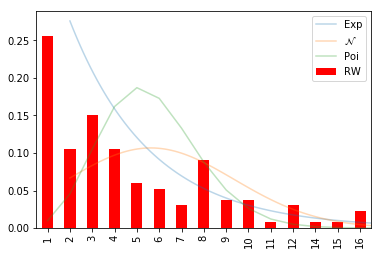

In [170]:
from scipy.stats import expon, gamma, norm

x = np.linspace(1,16,100)
plt.plot(x, expon(*expon.fit(banjir_feb['jumlah_rw'])).pdf(x), alpha=0.3, label='Exp')
plt.plot(x, norm(*norm.fit(banjir_feb['jumlah_rw'])).pdf(x), alpha=0.3, label='$\mathcal{N}$')
plt.plot(k, poisson.pmf(k, 4.62), alpha=0.3, label='Poi')
banjir_feb['jumlah_rw'].value_counts(True).sort_index().plot.bar(color='red', label='RW')
plt.legend();

In [307]:
def nll(dist, data):
    display(HTML('$\mathcal L(\\theta)= {:.2f}$'.format(
        -dist.nnlf(dist.fit(data), data)
    )))

In [309]:
data = banjir_feb['jumlah_rw']
display(HTML('$\mathcal L(\\theta)= {:.2f}$'.format(
    poisson(data.mean()).logpmf(data).sum()
)))
nll(norm, data)
nll(expon, data)

### Soal 1.4.a

Berdasarkan data historis, berapa rata-rata hari hujan di bulan Februari di Jakarta?

In [207]:
curah.query('bulan == 2')['banyak_hari_hujan'].mean()

19.2

### Soal 1.4.b

Jika diasumsikan bahwa banjir terjadi saat hari hujan per bulan di atas 3 minggu, berapa peluang banjir terjadi di bulan Februari 2015? Gambarkan distribusinya!

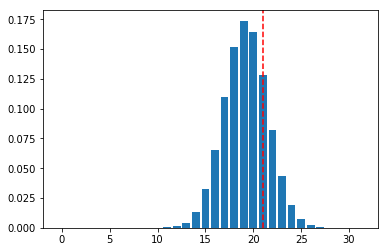

In [232]:
k = np.arange(32)
plt.bar(k, norm(*curah.query('bulan == 2')['banyak_hari_hujan'].agg(['mean','std'])).pdf(k))
plt.axvline(21, linestyle='--', c='r');
display(HTML('P(banjir)={:.2f}'.format(
    1-norm(*curah.query('bulan == 2')['banyak_hari_hujan'].agg(['mean','std'])).cdf(21)
)))

### Soal 1.5

Distribusi apa yang paling cocok untuk menggambarkan variabel curah hujan?

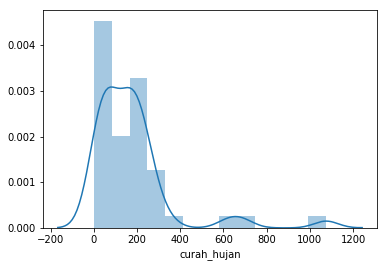

In [317]:
from scipy.stats import norm, skewnorm, t

x = curah['curah_hujan']
sns.distplot(x);
nll(norm, x)
nll(t, x)
nll(skewnorm, x)
nll(expon, x)

### Soal 1.6.a

Dua tahun kemudian ([Februari 2017](http://data.jakarta.go.id/dataset/data-tinggi-muka-air-di-dki-jakarta-tahun-2017/resource/e0f89dd5-7335-4bbd-837a-e6fad3520484)), diketahui bahwa rata-rata tinggi air di pintu air Pasar Ikan, Jakarta Utara, 169 cm dan standar deviasinya  adalah 19 cm. Jika peringatan status Siaga III banjir diberikan saat tinggi air antara 171-200 cm, berapa peluangnya pada bulan tersebut ada peringatan Siaga III? Gambarkan distribusinya.

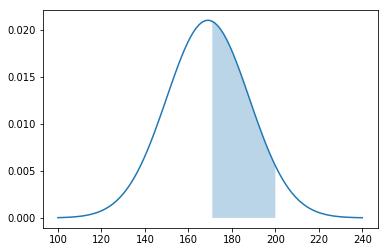

In [236]:
mu = 169
sigma = 19
x = np.linspace(100, 240, 100)
plt.plot(x, norm.pdf(x, mu, sigma))
xx = np.linspace(171, 200, 100)
plt.fill_between(xx, norm.pdf(xx, mu, sigma), alpha=0.3)
display(HTML('P(siaga3)={:.2f}'.format(
    norm.cdf(200, mu, sigma)-norm.cdf(171, mu, sigma)
)))

### Soal 1.6.b

Berdasarkan soal 1.6.a, jika status Siaga I di pintu air Pasar Ikan diberikan saat tinggi air minimal 251 cm, berapa peluangnya di bulan tersebut Anda akan mendapatkan peringatan Siaga I?

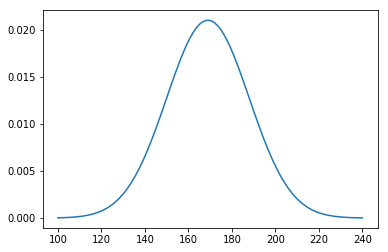

In [234]:
x = np.linspace(100, 240, 100)
plt.plot(x, norm.pdf(x, 169, 19))
display(HTML('P(siaga3)={:.2f}'.format(
    1-norm.cdf(251, 169, 19)
)))

## 2. Bugs!

Di suatu pusat data dengan 100 server, tiap *request* dialokasikan ke tiap server secara acak dengan peluang yang sama. Berdasarkan catatan, setiap server akan mendapatkan request sebanyak 2 per detik. Perusahaan yang menggunakan pusat data tersebut baru saja merilis kode ke semua server yang menyebabkan server akan *crash* jika mendapatkan lebih dari 6 requests per detik.

### Soal 2.a

Jika kita melihat satu server dan server lainya bekerja secara independen. Modelkan cara untuk menghitung peluang suatu server akan *crash* di detik berikutnya.

*Jawaban Anda di sini*

### Soal 2.b

Hitunglah nilai probabilitas dari soal 2.a.

In [328]:
display(HTML('$P(X>6)={:.4f}$'.format(
    1-poisson.cdf(6, mu=2)
)))

### Soal 2.c

Gambarkan grafik dari distribusi tersebut. Jangan lupa untuk memberikan label pada sumbu x dan y.

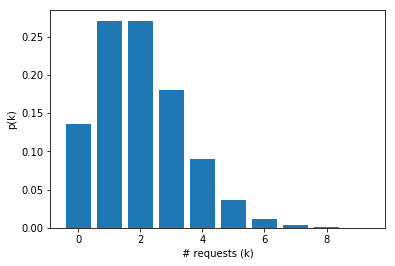

In [327]:
k = np.arange(10)
plt.bar(k, poisson(2).pmf(k))
plt.xlabel('# requests (k)')
plt.ylabel('p(k)');

### Soal 2.d

Berapa peluangnya bahwa tidak ada server yang akan *crash* di detik berikutnya?

In [336]:
display(HTML('$$P(X_1 \leq 6, X_2 \leq 6, ..., X_{100} \leq 6) = \prod_{i=1}^{100} P(X_i \leq 6) = %.4f$$' %
    poisson.cdf(6, mu=2)**100
))

### Soal 2.e

Gambarkan plot yang menunjukkan peluang tidak ada server yang *crash* detik berikutnya seiring dengan penambahan jumlahnya, i.e. peluang saat hanya 1 server, 2 server, 3 server, ..., 100 server.

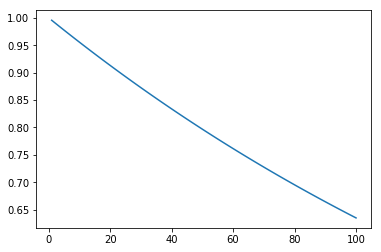

In [341]:
plt.plot(range(1,101), [poisson.cdf(6, mu=2)**i for i in range(1,101)]);